# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ]. 

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents. 


### 1. Determine if and why ML is an appropriate solution to deploy.

### Business Problem Summary:
In this scenario, our business problem revolves around predicting flight delays, a critical concern for both airlines and passengers. Flight delays not only lead to passenger inconvenience but also impact operational efficiency and customer satisfaction. Our goal is to develop a predictive model that accurately forecasts whether a flight will be delayed, allowing airlines to proactively manage schedules, allocate resources efficiently, and enhance overall customer experience. The primary business metric we're targeting is flight delay prediction accuracy, aiming for a high accuracy rate to ensure reliable predictions.

Machine Learning Problem Statement:
The task at hand is a binary classification problem. Given historical flight data including various features such as departure time, weather conditions, airline, and airport information, we aim to predict whether a flight will be delayed (class 1) or not (class 0). The problem can be formally stated as: Predict whether a flight will be delayed (class 1) or not (class 0) based on the provided features.

Type of Machine Learning:
This problem falls under supervised learning, where the model is trained on labeled historical data to make predictions. Specifically, it is a binary classification task as the outcome variable has two classes: delayed or not delayed. The goal is to develop a classification algorithm that can generalize patterns from the historical data to accurately classify unseen flight instances into the appropriate classes. Common algorithms for this type of problem include logistic regression, decision trees, random forests, and neural networks.# Write your answer here and turn the cell type into markdown

### 2. Formulate the business problem, success metrics, and desired ML output.

## Business Problem:
The business problem is to predict flight delays accurately, allowing airlines and passengers to plan their schedules effectively. Flight delays lead to passenger inconvenience, operational disruptions, and additional costs for airlines. By predicting delays in advance, airlines can optimize their schedules, reduce operational costs, and improve customer satisfaction.

Success Metrics:

Accuracy: The accuracy of the model in predicting whether a flight will be delayed or not is a critical metric. A high accuracy ensures reliable predictions.
Precision and Recall: Precision (the proportion of predicted delays that are correct) and recall (the proportion of actual delays that are predicted correctly) are essential for balancing false positives and false negatives. High precision ensures that when the model predicts a delay, it is likely to be accurate. High recall ensures that the model captures most of the actual delays.
F1 Score: The F1 score, which is the harmonic mean of precision and recall, provides a balanced measure of the model's accuracy.
ROC AUC: Receiver Operating Characteristic Area Under the Curve (ROC AUC) is crucial for binary classification problems. It measures the ability of the model to distinguish between delayed and non-delayed flights.
Prediction Lead Time: The average lead time (in minutes or hours) by which the model predicts delays before the scheduled departure time. This metric is important for airlines to make proactive decisions.
Desired ML Output:
The desired ML output is a binary classification model that predicts whether a flight will be delayed or not. For each flight instance, the model will output a probability score indicating the likelihood of delay. Additionally, the model can provide insights into the significant features contributing to the delay predictions, enabling airlines to understand the reasons behind the delays. The model should be capable of real-time predictions and be easily integrated into the airline's operational systems for seamless decision-making.

Write your answer here and turn the cell type into markdown

### 3. Identify the type of ML problem you’re dealing with.

In [2]:
# Write your answer here and turn the cell type into markdown

### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

In [77]:
import os
from pathlib import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess
import glob
import time

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# <please add any other library or function you are aiming to import here>


# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [275]:
# download the files

# <note: make them all relative, absolute path is not accepted>
zip_path = 'zip_file'
base_path = 'coding'
csv_base_path = 'extracted'

os.makedirs(zip_path, exist_ok=True)
os.makedirs(base_path, exist_ok=True)
os.makedirs(csv_base_path, exist_ok=True)


In [276]:


# Specify the relative path to the directory containing zip files
zip_path = 'zip_file'

# Use glob to find all zip files in the specified directory
zip_files = glob.glob(f"{zip_path}/*.zip")

# Count the number of zip files
number_of_zip_files = len(zip_files)

print(f"Number of zip files: {number_of_zip_files}")



Number of zip files: 60


#### Extract CSV files from ZIP files

In [8]:
def zip2csv(zipFile_name , file_path):
    """
    Extract csv from zip files
    zipFile_name: name of the zip file
    file_path : name of the folder to store csv
    """

    try:
        with ZipFile(zipFile_name, 'r') as z: 
            print(f'Extracting {zipFile_name} ') 
            z.extractall(path=file_path) 
    except:
        print(f'zip2csv failed for {zipFile_name}')

for file in zip_files:
    zip2csv(file, csv_base_path)

print("Files Extracted")

Extracting zip_file\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip 
Extracting zip_file\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_5.zip 
Extracting zip_file\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_6.zip 
Extracting zip_file\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_7.zip 
Extracting zip_file\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_8.zip 
Extracting zip_file\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_9.zip 
Extracting zip_file\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2017_1.zip 
Extracting zip_file\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2017_10.zip 
Extracting zip_file\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2017_11.zip 
Extracting zip_file\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2017_12.zip 
Extracting zip_file\On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2017_2.z

In [277]:
# Specify the relative path to the directory where CSV files are extracted
csv_base_path = 'extracted'

# Use glob to find all CSV files in the specified directory
csv_files = glob.glob(os.path.join(csv_base_path, '*.csv'))

# Count the number of CSV files
number_of_csv_files = len(csv_files)

print(f"Number of CSV files extracted: {number_of_csv_files}")


Number of CSV files extracted: 60


Before loading the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information on the features included in the dataset.

In [81]:
import os
from IPython.display import IFrame

# Assuming csv_base_path is the directory where readme.html is located
html_file_path = os.path.join(csv_base_path, "readme.html")

IFrame(src=html_file_path, width=1000, height=600)


#### Load sample CSV

Before combining all the CSV files, get a sense of the data from a single CSV file. Using Pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the Python built-in `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [278]:
import pandas as pd
csv_file_path = 'extracted/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv'
df= pd.read_csv(csv_file_path)

# Specify the path to the CSV file (assuming it's in the same directory as your script/notebook)

df_temp = pd.read_csv(csv_file_path)


# Read the CSV file into a pandas DataFrame

# Now, df_temp contains the data from the CSV file


**Question**: Print the row and column length in the dataset, and print the column names.

In [279]:
df_shape = df_temp.shape

# Get the column names
column_names = df_temp.columns.tolist()

num_rows, num_cols = df_temp.shape

# Get the column names
column_names = df_temp.columns.tolist()

# Print the row and column lengths and column names
print(f'Number of rows: {num_rows}')
print(f'Number of columns: {num_cols}')
print(f'Column names: {column_names}')

print(f'Rows and columns in one csv file is {df_shape}')

Number of rows: 585749
Number of columns: 110
Column names: ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'Reporting_Airline', 'DOT_ID_Reporting_Airline', 'IATA_CODE_Reporting_Airline', 'Tail_Number', 'Flight_Number_Reporting_Airline', 'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'Origin', 'OriginCityName', 'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'Dest', 'DestCityName', 'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'CRSDepTime', 'DepTime', 'DepDelay', 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrTime', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 'ArrTimeBlk', 'Cancelled', 'CancellationCode', 'Diverted', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'Flights', 'Distance', 'DistanceGroup', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'Security

**Question**: Print the first 10 rows of the dataset.  

In [84]:
# Enter your import pandas as pd

# Specify the path to the CSV file (assuming it's in the same directory as your script/notebook)


# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Print the first 10 rows of the dataset
print(df_temp.head(10))


   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2018        3      9           3          1  2018-09-03                9E   
1  2018        3      9           9          7  2018-09-09                9E   
2  2018        3      9          10          1  2018-09-10                9E   
3  2018        3      9          13          4  2018-09-13                9E   
4  2018        3      9          14          5  2018-09-14                9E   
5  2018        3      9          16          7  2018-09-16                9E   
6  2018        3      9          17          1  2018-09-17                9E   
7  2018        3      9          20          4  2018-09-20                9E   
8  2018        3      9          21          5  2018-09-21                9E   
9  2018        3      9          23          7  2018-09-23                9E   

   DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number  \
0                     20363                     

**Question**: Print all the columns in the dataset. Use `<dataframe>.columns` to view the column names.

In [19]:
print(f'The column names are :')
print('#########')
for col in df_temp.columns:
    print(col)

The column names are :
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1

**Question**: Print all the columns in the dataset that contain the word 'Del'. This will help you see how many columns have delay data in them.

**Hint**: You can use a Python list comprehension to include values that pass certain `if` statement criteria.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: You can use the `in` keyword ([documentation](https://www.w3schools.com/python/ref_keyword_in.asp)) to check if the value is in a list or not. 

For example: `5 in [1,2,3,4,5]`

In [280]:
# Enter your codedelay_columns = [col for col in df_temp.columns if 'Del' in col]

# Print columns containing the word 'Del'
delay_columns = [col for col in df_temp.columns if 'Del' in col]
print(f'Columns containing the word "Del" are:')
print('#########')
for col in delay_columns:
    print(col)

Columns containing the word "Del" are:
#########
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
DivArrDelay


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [86]:
# to answer above questions, complete the following code
um_rows, num_columns = df_temp.shape

# Years included in the dataset
years_in_dataset = df_temp['Year'].unique()

# Months covered in the dataset
months_in_dataset = df_temp['Month'].unique()

# Date range for the dataset
date_range_start = df_temp['FlightDate'].min()
date_range_end = df_temp['FlightDate'].max()

# Airlines included in the dataset
airlines_in_dataset = df_temp['Reporting_Airline'].unique()

# Origin and destination airports covered
origin_airports = df_temp['Origin'].unique()
destination_airports = df_temp['Dest'].unique()
print("The #rows and #columns are ", num_rows, " and ", num_columns)
print("The years in this dataset are: ", list(years_in_dataset))
print("The months covered in this dataset are: ", list(months_in_dataset))
print("The date range for data is: ", date_range_start, " to ", date_range_end)
print("The airlines covered in this dataset are: ", list(airlines_in_dataset))
print("The Origin airports covered are: ", list(origin_airports))
print("The Destination airports covered are: ", list(destination_airports))

The #rows and #columns are  585749  and  110
The years in this dataset are:  [2018]
The months covered in this dataset are:  [9]
The date range for data is:  2018-09-01  to  2018-09-30
The airlines covered in this dataset are:  ['9E', 'B6', 'WN', 'YV', 'YX', 'EV', 'AA', 'AS', 'DL', 'HA', 'UA', 'F9', 'G4', 'MQ', 'NK', 'OH', 'OO']
The Origin airports covered are:  ['DFW', 'LGA', 'MSN', 'MSP', 'ATL', 'BDL', 'VLD', 'JFK', 'RDU', 'CHS', 'DTW', 'GRB', 'PVD', 'SHV', 'FNT', 'PIT', 'RIC', 'RST', 'RSW', 'CVG', 'LIT', 'ORD', 'JAX', 'TRI', 'BOS', 'CWA', 'DCA', 'CHO', 'AVP', 'IND', 'GRR', 'BTR', 'MEM', 'TUL', 'CLE', 'STL', 'BTV', 'OMA', 'MGM', 'TVC', 'SAV', 'GSP', 'EWR', 'OAJ', 'BNA', 'MCI', 'TLH', 'ROC', 'LEX', 'PWM', 'BUF', 'AGS', 'CLT', 'GSO', 'BWI', 'SAT', 'PHL', 'TYS', 'ACK', 'DSM', 'GNV', 'AVL', 'BGR', 'MHT', 'ILM', 'MOT', 'IAH', 'SBN', 'SYR', 'ORF', 'MKE', 'XNA', 'MSY', 'PBI', 'ABE', 'HPN', 'EVV', 'ALB', 'LNK', 'AUS', 'PHF', 'CHA', 'GTR', 'BMI', 'BQK', 'CID', 'CAK', 'ATW', 'ABY', 'CAE', 'SRQ

**Question**: What is the count of all the origin and destination airports?

**Hint**: You can use the Pandas `values_count` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)) to find out the values for each airport using the columns `Origin` and `Dest`.

In [281]:
origin_counts = df_temp['Origin'].value_counts()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Count the occurrences of each destination airport
destination_counts = df_temp['Dest'].value_counts()
counts = pd.DataFrame({'Origin':origin_counts, 'Destination': destination_counts})
print(counts)

     Origin  Destination
ABE     303          303
ABI     169          169
ABQ    2077         2076
ABR      60           60
ABY      79           79
ACK     129          129
ACT     135          135
ACV     122          122
ACY     242          242
ADK       9            9
ADQ      51           51
AEX     278          279
AGS     394          394
ALB     904          904
ALO      55           55
AMA     465          466
ANC    1562         1559
APN      51           51
ASE     373          371
ATL   31525        31521
ATW     294          294
AUS    5224         5224
AVL     678          678
AVP     305          305
AZA     315          315
AZO     258          258
BDL    2232         2232
BET      68           68
BFF      50           50
BFL     193          193
BGM      85           85
BGR     437          437
BHM    1536         1536
BIL     284          283
BIS     317          317
BJI      60           60
BKG      17           17
BLI     114          114
BLV      56           56


**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the Pandas `sort_values` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [282]:
top_origin_airports= counts.sort_values(by='Origin',ascending=False).head(15 )
top_destination_airports= counts.sort_values(by='Destination',ascending=False).head(15 )# Enter your code here
print("Top 15 Origin and Destination Airports:")
print(top_origin_airports)
print(top_destination_airports)


Top 15 Origin and Destination Airports:
     Origin  Destination
ATL   31525        31521
ORD   28257        28250
DFW   22802        22795
DEN   19807        19807
CLT   19655        19654
LAX   17875        17873
SFO   14332        14348
IAH   14210        14203
LGA   13850        13850
MSP   13349        13347
LAS   13318        13322
PHX   13126        13128
DTW   12725        12724
BOS   12223        12227
SEA   11872        11877
     Origin  Destination
ATL   31525        31521
ORD   28257        28250
DFW   22802        22795
DEN   19807        19807
CLT   19655        19654
LAX   17875        17873
SFO   14332        14348
IAH   14210        14203
LGA   13850        13850
MSP   13349        13347
LAS   13318        13322
PHX   13126        13128
DTW   12725        12724
BOS   12223        12227
SEA   11872        11877


**Question**: Given all the information about a flight trip, can you predict if it would be delayed?

Yes, with the right information and a trained machine learning model, we can forecast whether a flight will be delayed. You can develop a predictive model, such as a classification model, to determine the likelihood of a flight being delayed by analyzing previous data and relevant parameters such as departure time, origin, destination, airline, and weather conditions.

Delays can be predicted using factors such as departure time, weather conditions, and airline performance. To anticipate flight delays, machine learning techniques such as logistic regression, random forests, or neural networks can be trained on these features.

Preprocessing and cleaning the data is critical, as is selecting acceptable features, engineering relevant characteristics (such as holidays, as described in your previous question), and properly training and evaluating the model.

Now, assume you are traveling from San Francisco to Los Angeles on a work trip. You want to have an ideas if your flight will be delayed, given a set of features, so that you can manage your reservations in Los Angeles better. How many features from this dataset would you know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or destination. If there were a sudden weather delay 10 minutes before landing, this data would not be helpful in managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top 5 airlines: UA, OO, WN, AA, DL

This should help in reducing the size of data across the CSV files to be combined.

#### Combine all CSV files

**Hint**:  
First, create an empy dataframe that you will use to copy your individual dataframes from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe  
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the subset_vals in each of the subset_cols. Use the `isin` Pandas function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)) to check if the `val` is in the dataframe column and then choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the dataframe with the empty dataframe 

In [27]:


def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name):
    """
    Combine csv files into one Data Frame
    csv_files: list of csv file paths
    filter_cols: list of columns to filter
    subset_cols: list of columns to subset rows
    subset_vals: list of list of values to subset rows
    file_name: output file name
    """
    # Create an empty dataframe
    df = pd.DataFrame()
    
    for file in csv_files:
        temp_df = pd.read_csv(file)
        temp_df = temp_df[filter_cols]
        for col, vals in zip(subset_cols, subset_vals):
            temp_df = temp_df[temp_df[col].isin(vals)]
        df = pd.concat([df, temp_df], ignore_index=True)
    
    # Save the combined dataframe to a CSV file
    df.to_csv(file_name, index=False)
    print(f"Combined data saved to {file_name}")
    return df

# Specify the path to your CSV files
csv_files = glob.glob(os.path.join(csv_base_path, '*.csv'))  

# Columns to keep in the final output
filter_cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
                'Reporting_Airline','Origin','OriginState','Dest','DestState',
                'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
                'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

# Columns to subset rows based on values
subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# Values to subset rows for each subset column
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['UA', 'OO', 'WN', 'AA', 'DL']]

output_file_name = 'combined_data.csv'
start = time.time()

# Call the function to combine and save the data
combined_df = combine_csv(csv_files, filter_cols, subset_cols, subset_vals, output_file_name)

combined_csv_filename = f"{base_path}combined_files.csv"

# Measure the time taken for merging
print(f'CSV files merged in {round((time.time() - start) / 60, 2)} minutes')


Combined data saved to combined_data.csv
CSV files merged in 4.16 minutes


Use the function above to merge all the different files into a single file that you can read easily. 

**Note**: This will take 5-7 minutes to complete.

#### Load dataset

Load the combined dataset.

In [338]:
data = pd.read_csv('combined_data.csv')



Print the first 5 records.

In [339]:

print(data.head(5))# Enter your code here 

   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2014        1      1          26          7  2014-01-26                DL   
1  2014        1      1          26          7  2014-01-26                DL   
2  2014        1      1          26          7  2014-01-26                DL   
3  2014        1      1          26          7  2014-01-26                DL   
4  2014        1      1          26          7  2014-01-26                DL   

  Origin OriginState Dest DestState  CRSDepTime  Cancelled  Diverted  \
0    ATL          GA  IAH        TX        2145        0.0       0.0   
1    DFW          TX  ATL        GA         945        0.0       0.0   
2    ATL          GA  DEN        CO        1855        0.0       0.0   
3    ATL          GA  PHX        AZ        1634        0.0       0.0   
4    PHX          AZ  ATL        GA         700        0.0       0.0   

   Distance  DistanceGroup  ArrDelay  ArrDelayMinutes  ArrDel15  AirTime  
0     689.0

Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [340]:
# to answer above questions, complete the following code
# Number of rows and columns
combined_data = pd.read_csv('combined_data.csv')
num_rows, num_columns = combined_data.shape
print(f"The #rows and #columns are {num_rows} and {num_columns}")

# Unique years
unique_years = combined_data['Year'].unique()
print(f"The years in this dataset are: {list(unique_years)}")

# Unique months
unique_months = combined_data['Month'].unique()
print(f"The months covered in this dataset are: {sorted(list(unique_months))}")

# Date range
min_date = combined_data['FlightDate'].min()
max_date = combined_data['FlightDate'].max()
print(f"The date range for data is: {min_date} to {max_date}")

# Unique airlines
unique_airlines = combined_data['Reporting_Airline'].unique()
print(f"The airlines covered in this dataset are: {list(unique_airlines)}")

# Unique origin airports
unique_origin_airports = combined_data['Origin'].unique()
print(f"The Origin airports covered are: {list(unique_origin_airports)}")

# Unique destination airports
unique_destination_airports = combined_data['Dest'].unique()
print(f"The Destination airports covered are: {list(unique_destination_airports)}")


The #rows and #columns are 1658130 and 20
The years in this dataset are: [2014, 2015, 2016, 2017, 2018]
The months covered in this dataset are: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
The date range for data is: 2014-01-01 to 2018-12-31
The airlines covered in this dataset are: ['DL', 'OO', 'WN', 'UA', 'AA']
The Origin airports covered are: ['ATL', 'DFW', 'PHX', 'DEN', 'IAH', 'CLT', 'SFO', 'LAX', 'ORD']
The Destination airports covered are: ['IAH', 'ATL', 'DEN', 'PHX', 'CLT', 'LAX', 'DFW', 'SFO', 'ORD']


Let's define our **target column : is_delay** (1 - if arrival time delayed more than 15 minutes, 0 - otherwise). Use the `rename` method to rename the column from `ArrDel15` to `is_delay`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

For example:
```
df.rename(columns={'col1':'column1'}, inplace=True)
```

In [341]:
# Renaming ArrDelay15 ti is_delay
combined_data.rename(columns={'ArrDel15': 'is_delay'}, inplace=True)
print(combined_data.columns)
# Enter your code here


Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime'],
      dtype='object')


Look for nulls across columns. You can use the `isnull()` function ([documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Hint**: `isnull()` detects whether the particular value is null or not and gives you a boolean (True or False) in its place. Use the `sum(axis=0)` function to sum up the number of columns.

In [342]:
# Enter your# Check for null values across columns and sum them up
null_counts = combined_data.isnull().sum(axis=0)

# Print the number of null values in each column
print("Number of null values in each column:")
print(null_counts)

Number of null values in each column:
Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
Cancelled                0
Diverted                 0
Distance                 0
DistanceGroup            0
ArrDelay             22540
ArrDelayMinutes      22540
is_delay             22540
AirTime              22540
dtype: int64


The arrival delay details and airtime are missing for 22540 out of 1658130 rows, which is 1.3%. You can either remove or impute these rows. The documentation does not mention anything about missing rows.

**Hint**: Use the `~` operator to choose the values that aren't null from the `isnull()` output.

For example:
```
null_eg = df_eg[~df_eg['column_name'].isnull()]
```

In [343]:
### Remove null columns
# Remove rows with missing values in 'ArrDelay' and 'AirTime' columns
combined_data_cleaned = combined_data[~(combined_data['ArrDelay'].isnull() | combined_data['AirTime'].isnull())]

# Calculate the percentage of removed rows
removed_percentage = (1 - len(combined_data_cleaned) / len(combined_data)) * 100

print(f"The arrival delay details and airtime are missing for {len(combined_data) - len(combined_data_cleaned)} out of {len(combined_data)} rows, which is {removed_percentage:.1f}%.")

# Now combined_data_cleaned contains rows without missing values in 'ArrDelay' and 'AirTime' columns


The arrival delay details and airtime are missing for 22540 out of 1658130 rows, which is 1.4%.


Get the hour of the day in 24-hour time format from CRSDepTime.

In [344]:
combined_data_cleaned['DepHourofDay'] = combined_data_cleaned['CRSDepTime'].astype(str).str.zfill(4).str[:2]

# Convert the resulting column to numeric type
combined_data_cleaned['DepHourofDay'] = combined_data_cleaned['DepHourofDay'].astype(int)# Enter your code here

## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only 0/1 value, you could use a classification algorithm. 

### Data exploration

#### Check class delay vs. no delay

**Hint**: Use a `groupby` plot ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) with a `bar` plot ([documentation](https://matplotlib.org/tutorials/introductory/pyplot.html)) to plot the frequency vs. distribution of the class.

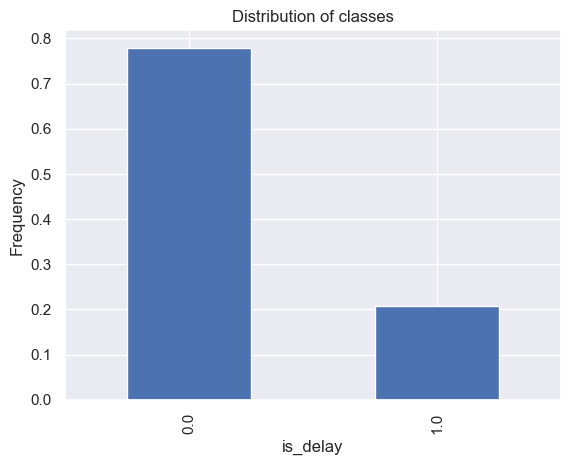

In [346]:
(combined_data_cleaned.groupby('is_delay').size() / len(data)).plot(kind='bar')
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()# Enter your code here


**Question**: What can you deduce from the bar plot about the ratio of delay vs. no delay?

The following can be deduced from the bar plot depicting the distribution of delay vs. no delay:

Class Imbalance: A class imbalance occurs when one class (delay or no delay) greatly outnumbers the other in terms of frequency. Both classes would have about identical frequencies in a balanced dataset. Imbalanced classes can have an effect on the performance of machine learning models, particularly those that are sensitive to class distribution.

Potential Difficulties: If there is a severe class imbalance, model training may be difficult. Models trained on imbalanced datasets may become biased towards the majority, resulting in bad predictions for the minority. In such circumstances, the handling of class imbalance, such as oversampling, undersampling, or employing suitable assessment criteria, is critical.
Model Interpretation: Understanding the distribution of classes aids in comprehending the model's output. For example, if delays are uncommon, the model may be good at recognizing non-delayed flights but may struggle to forecast delays due to a shortage of delay cases in the dataset.

In conclusion, a balanced or imbalanced class distribution can have a considerable impact on the model's performance and interpretation, emphasizing the necessity of properly handling class imbalances while designing predictive models.














**Questions**: 

- Which months have the most delays?
- What time of the day has the most delays?
- What day of the week has the most delays?
- Which airline has the most delays?
- Which origin and destination airports have the most delays?
- Is flight distance a factor in the delays?

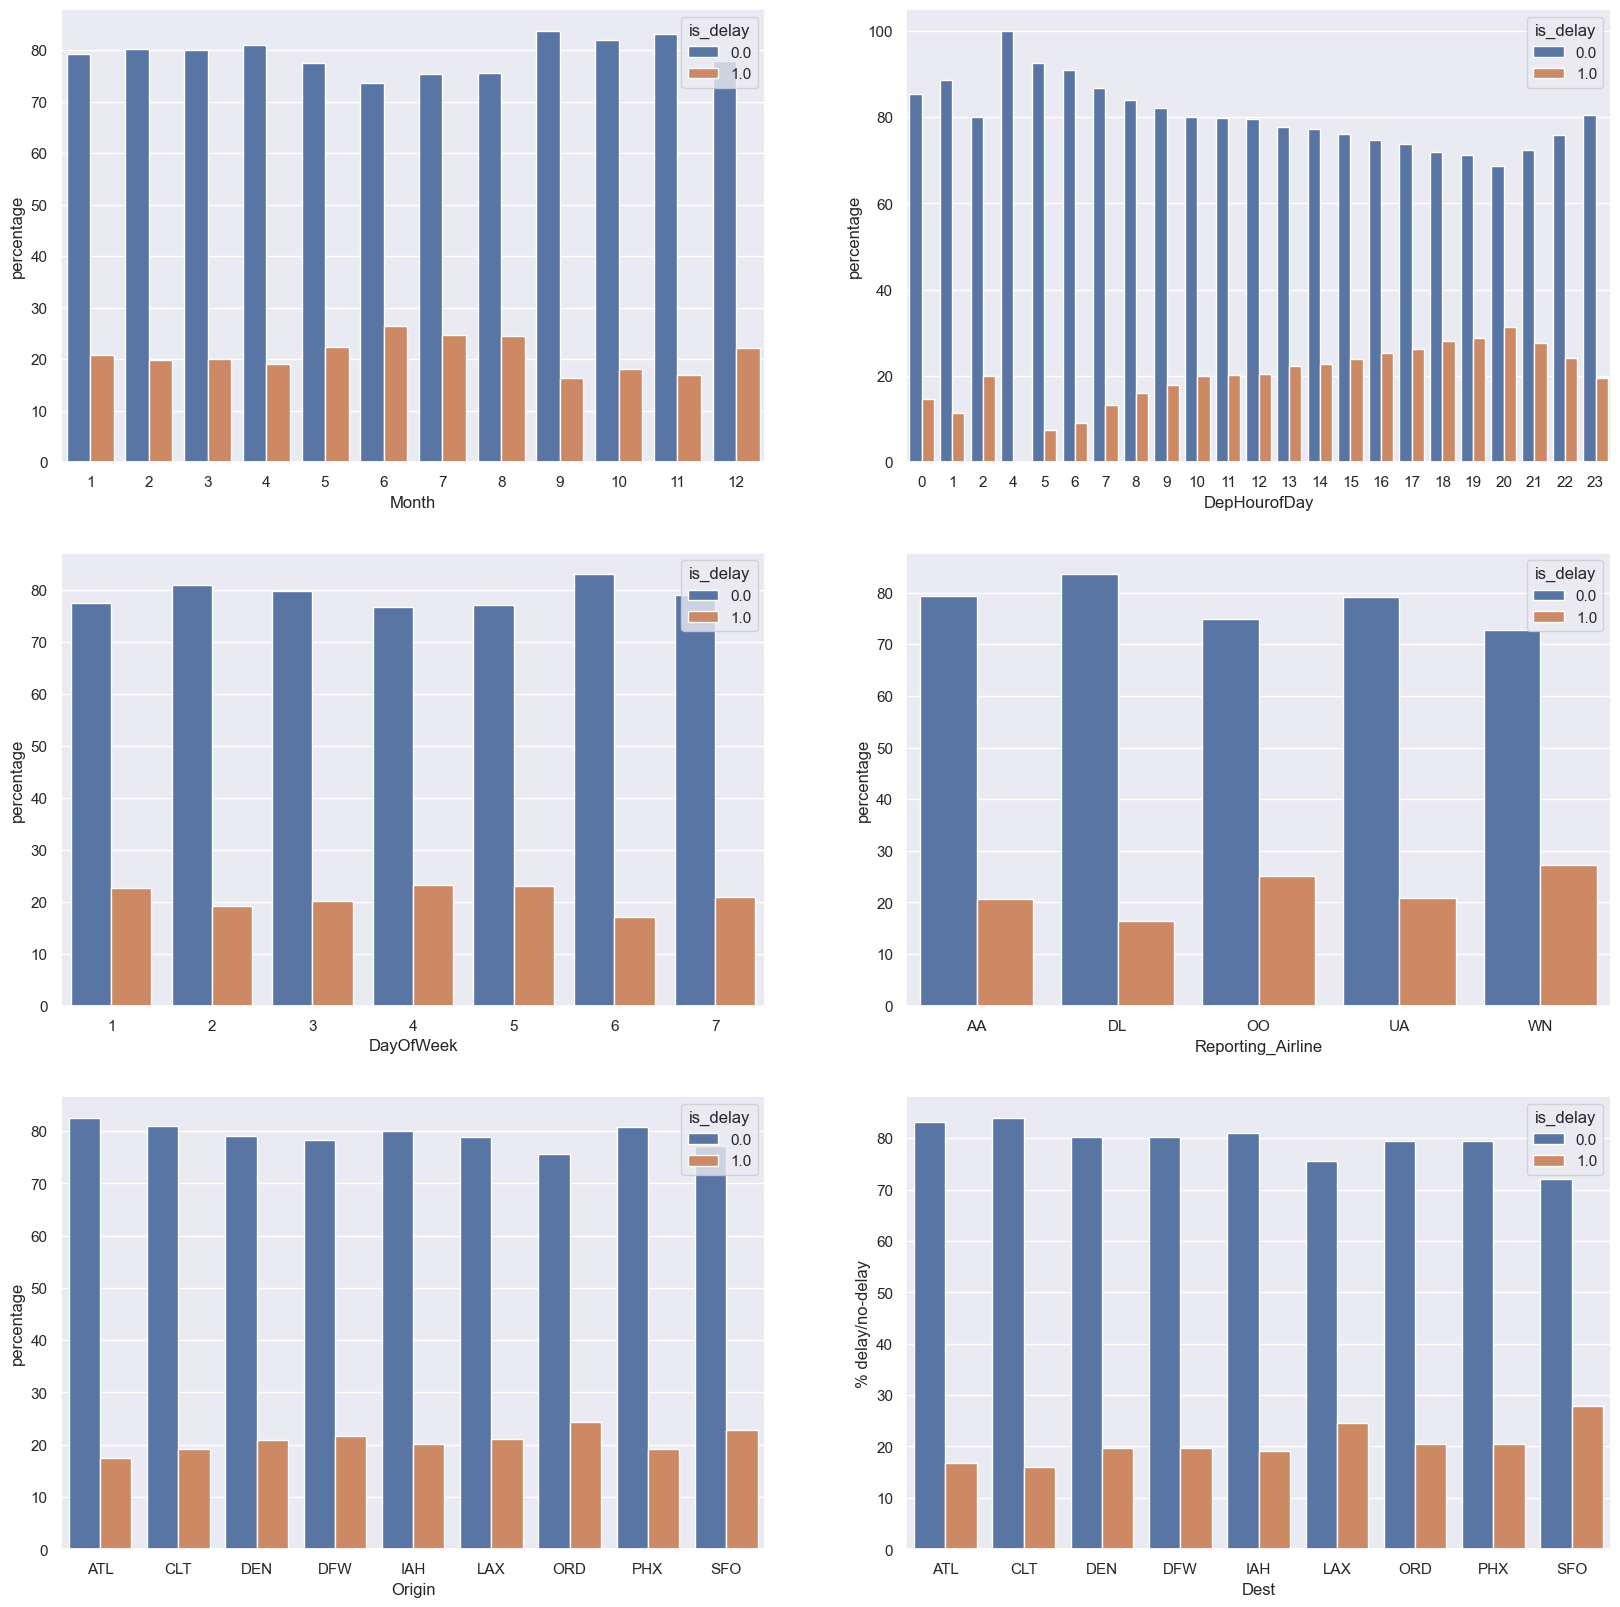

In [193]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
# fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = combined_data_cleaned.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')
    

plt.show()

   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2014        1      1          26          7  2014-01-26                DL   
1  2014        1      1          26          7  2014-01-26                DL   
2  2014        1      1          26          7  2014-01-26                DL   
3  2014        1      1          26          7  2014-01-26                DL   
4  2014        1      1          26          7  2014-01-26                DL   

  Origin OriginState Dest DestState  CRSDepTime  Cancelled  Diverted  \
0    ATL          GA  IAH        TX        2145        0.0       0.0   
1    DFW          TX  ATL        GA         945        0.0       0.0   
2    ATL          GA  DEN        CO        1855        0.0       0.0   
3    ATL          GA  PHX        AZ        1634        0.0       0.0   
4    PHX          AZ  ATL        GA         700        0.0       0.0   

   Distance  DistanceGroup  ArrDelay  ArrDelayMinutes  is_delay  AirTime  \
0     689.

KeyError: "['is_delay'] not in index"

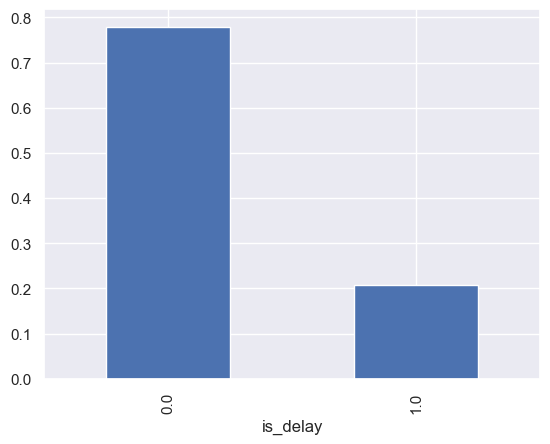

In [347]:
print(combined_data_cleaned.head())
(combined_data_cleaned.groupby('is_delay').size() / len(data)).plot(kind='bar')


sns.lmplot(x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2014        1      1          26          7  2014-01-26                DL   
1  2014        1      1          26          7  2014-01-26                DL   
2  2014        1      1          26          7  2014-01-26                DL   
3  2014        1      1          26          7  2014-01-26                DL   
4  2014        1      1          26          7  2014-01-26                DL   

  Origin OriginState Dest DestState  CRSDepTime  Cancelled  Diverted  \
0    ATL          GA  IAH        TX        2145        0.0       0.0   
1    DFW          TX  ATL        GA         945        0.0       0.0   
2    ATL          GA  DEN        CO        1855        0.0       0.0   
3    ATL          GA  PHX        AZ        1634        0.0       0.0   
4    PHX          AZ  ATL        GA         700        0.0       0.0   

   Distance  DistanceGroup  ArrDelay  ArrDelayMinutes  is_delay  AirTime  \
0     689.

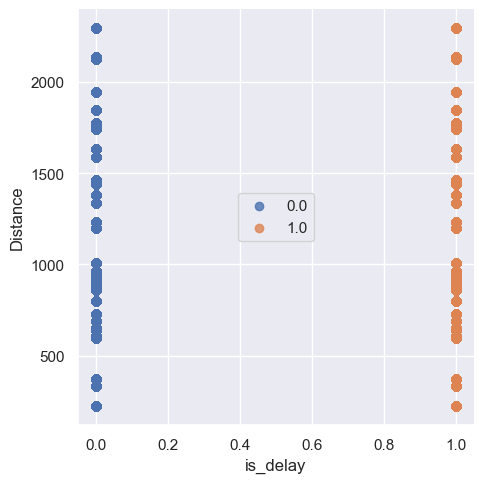

In [195]:
# Assuming 'ArrDelayMinutes' is the correct column representing delay in minutes
print(combined_data_cleaned.head())

# Plot the distribution of classes (delay vs. no delay)
# Plotting the relationship between 'is_delay' and 'Distance'
sns.lmplot(x="is_delay", y="Distance", data=combined_data_cleaned, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()


In [ ]:
# Based on the above figures, enter your answers to the above questions here and turn the cell type to markdown

### Features

Look at all the columns and what their specific types are.

In [348]:
combined_data_cleaned.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay'],
      dtype='object')

In [349]:
combined_data_cleaned.dtypes

Year                   int64
Quarter                int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginState           object
Dest                  object
DestState             object
CRSDepTime             int64
Cancelled            float64
Diverted             float64
Distance             float64
DistanceGroup          int64
ArrDelay             float64
ArrDelayMinutes      float64
is_delay             float64
AirTime              float64
DepHourofDay           int32
dtype: object

Filtering the required columns:
- Date is redundant, because you have Year, Quarter, Month, DayofMonth, and DayOfWeek to describe the date.
- Use Origin and Dest codes instead of OriginState and DestState.
- Because you are just classifying whether the flight is delayed or not, you don't need TotalDelayMinutes, DepDelayMinutes, and ArrDelayMinutes.

Treat DepHourofDay as a categorical variable because it doesn't have any quantitative relation with the target.
- If you had to do a one-hot encoding of it, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- Just split into buckets here.

**Hint**: To change a column type to category, use the `astype` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [350]:
# Print the first few rows of the updated dataset
print(data.head())
data_orig = combined_data_cleaned.copy()
# Convert DepHourofDay to a categorical variable


# Print the first few rows of the updated dataset


data = data_orig[['is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
                  'Reporting_Airline', 'Origin', 'Dest', 'Distance', 'DepHourofDay']]

# List of categorical columns
categorical_columns  = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay']

# Convert categorical columns to category data type
for c in categorical_columns:
    data[c] = data[c].astype('category')

# Print the first few rows of the filtered and processed data
print(data.head())# Enter your code here


   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2014        1      1          26          7  2014-01-26                DL   
1  2014        1      1          26          7  2014-01-26                DL   
2  2014        1      1          26          7  2014-01-26                DL   
3  2014        1      1          26          7  2014-01-26                DL   
4  2014        1      1          26          7  2014-01-26                DL   

  Origin OriginState Dest DestState  CRSDepTime  Cancelled  Diverted  \
0    ATL          GA  IAH        TX        2145        0.0       0.0   
1    DFW          TX  ATL        GA         945        0.0       0.0   
2    ATL          GA  DEN        CO        1855        0.0       0.0   
3    ATL          GA  PHX        AZ        1634        0.0       0.0   
4    PHX          AZ  ATL        GA         700        0.0       0.0   

   Distance  DistanceGroup  ArrDelay  ArrDelayMinutes  ArrDel15  AirTime  
0     689.0

To use one-hot encoding, use the Pandas `get_dummies` function for the categorical columns that you selected above. Then, you can concatenate those generated features to your original dataset using the Pandas `concat` function. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information on dummy encoding, see https://en.wikiversity.org/wiki/Dummy_variable_(statistics).

For example:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [351]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True) # Enter your code here
data = pd.concat([data, data_dummies], axis=1)
data.drop(categorical_columns,axis=1, inplace=True)

Check the length of the dataset and the new columnms.

In [352]:
num_rows, num_columns = data.shape

# Print the length of the dataset and the number of columns
print(f"Number of rows in the dataset: {num_rows}")
print(f"Number of columns in the dataset after one-hot encoding: {num_columns}")
data = pd.concat([data[['Distance', 'is_delay']], data_dummies], axis=1)

# Get the column names after one-hot encoding
encoded_columns = data.columns

# Print the column names
print(encoded_columns)# Enter your code here

Number of rows in the dataset: 1635590
Number of columns in the dataset after one-hot encoding: 94
Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Report

**Sample Answer:** 
```
Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO'],
      dtype='object')
```

Now you are ready to do model training. Before splitting the data, rename the column `is_delay` to `target`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [353]:
data.rename(columns = {'is_delay': 'target'}, inplace=True)# Enter your code here

In [354]:
# write code to Save the combined csv file (combined_csv_v1.csv) to your local computer
# Save the combined DataFrame to a CSV file
data.to_csv('combined_csv_v1.csv', index=False)

combined_csv_v1.csv = pd.read_csv('combined_csv_v1.csv')

print("Combined CSV file saved successfully as 'combined_csv_v1.csv'.")

# note this combined file will be used in part B

Combined CSV file saved successfully as 'combined_csv_v1.csv'.


# Step 3: Model training and evaluation

1. Split the data into `train_data`, and `test_data` using `sklearn.model_selection.train_test_split`.  
2. Build a logistic regression model for the data, where training data is 80%, and test data is 20%.

Use the following cells to complete these steps. Insert and delete cells where needed.


### Train test split

In [298]:


# Load data from the CSV file
data = pd.read_csv('combined_csv_v1.csv')

# Assuming 'target' is the target column, and you want to drop it from the features
X = data.drop(columns=['target'])
y = data['target']

# Split data into training (80%) and temporary data (20%)
train_data, temp_data, train_labels, temp_labels = train_test_split(X, y, test_size=0.2, random_state=42)

# Split temporary data into validation (50%) and test (50%) sets
validation_data, test_data, validation_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42)

# Initialize and train the logistic regression model
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(train_data, train_labels)

# Make predictions on the test data
predictions = logreg_model.predict(test_data)

# Evaluate the model
accuracy = accuracy_score(test_labels, predictions)
print("Model Accuracy:", accuracy)

# Check the shapes of the datasets
print("Training data shape:", train_data.shape)
print("Training labels shape:", train_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)



Model Accuracy: 0.7900084984623286
Training data shape: (1308472, 93)
Training labels shape: (1308472,)
Test data shape: (163559, 93)
Test labels shape: (163559,)


### Baseline classification model

In [207]:
# Calculate the mode of the 'is_delay' column
baseline_prediction = train_labels.mode()[0]

# Create a list of baseline predictions for the validation and test sets
baseline_predictions_validation = [baseline_prediction] * len(validation_labels)
baseline_predictions_test = [baseline_prediction] * len(test_labels)

# Evaluate the accuracy of the baseline model on the validation set
baseline_accuracy_validation = sum(baseline_predictions_validation == validation_labels) / len(validation_labels)
print("Baseline Accuracy on Validation Set:", baseline_accuracy_validation)

# Evaluate the accuracy of the baseline model on the test set
baseline_accuracy_test = sum(baseline_predictions_test == test_labels) / len(test_labels)
print("Baseline Accuracy on Test Set:", baseline_accuracy_test)
# <write code here>

Baseline Accuracy on Validation Set: 0.7900390684707047
Baseline Accuracy on Test Set: 0.7899473584455762


## Model evaluation
In this section, you'll evaluate your trained model on test data and report on the following metrics:
* Confusion Matrix plot
* Plot the ROC
* Report statistics such as Accuracy, Percision, Recall, Sensitivity and Specificity

To view a plot of the confusion matrix, and various scoring metrics, create a couple of functions:

In [299]:
def plot_confusion_matrix(test_labels, target_predicted):
    cm = confusion_matrix(test_labels, target_predicted)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Delayed', 'Delayed'], yticklabels=['Not Delayed', 'Delayed'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()



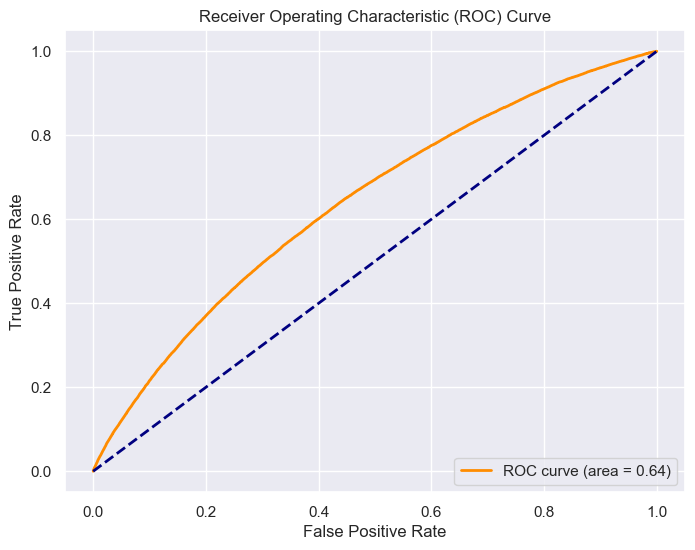

In [140]:
def plot_roc(test_labels, target_predicted):
    fpr, tpr, thresholds = metrics.roc_curve(test_labels, target_predicted)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

probs_positive_class = logreg_model.predict_proba(test_data)[:, 1]

# Assuming 'test_labels' contains the actual labels for the test data
plot_roc(test_labels, probs_positive_class)

    # complete the code here

To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and `target_predicted` data from your batch job:

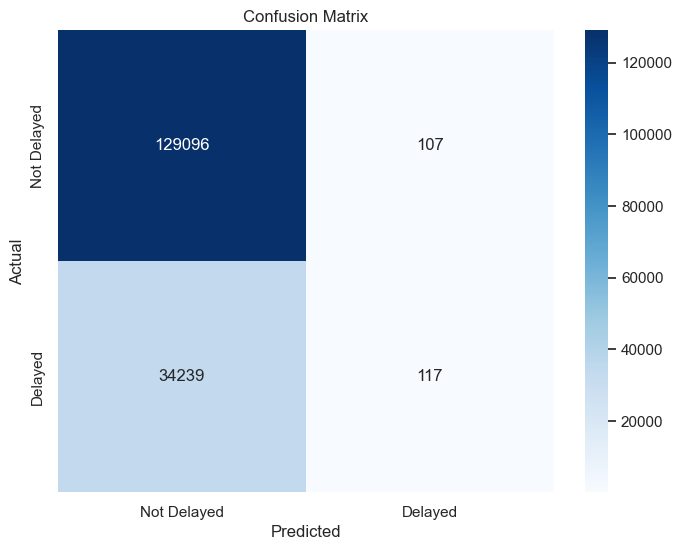

In [141]:
plot_confusion_matrix(test_labels, predictions)

To print statistics and plot an ROC curve, call the `plot_roc` function on the `test_labels` and `target_predicted` data from your batch job:

Accuracy: 0.7900084984623286
Precision: 0.5223214285714286
Recall: 0.003405518686692281
ROC AUC Score: 0.5012886822708325


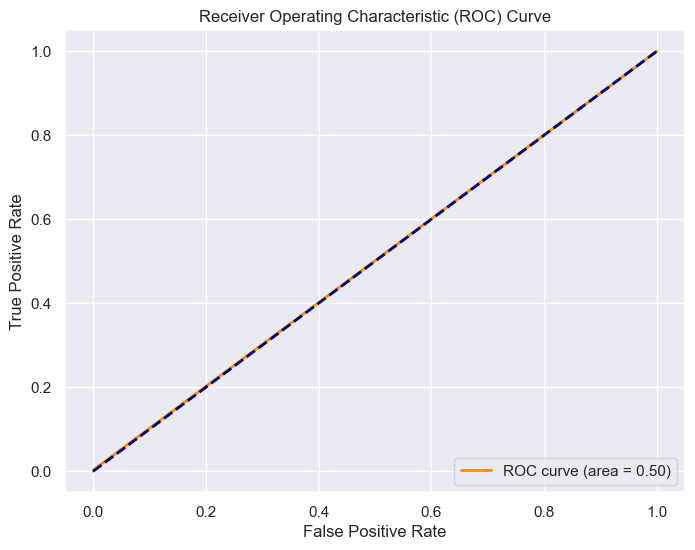

In [209]:


# Assuming 'predictions' contains the predicted labels and 'test_labels' contains the actual labels
# Calculate and display accuracy
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy:", accuracy)

# Calculate and display precision
precision = precision_score(test_labels, predictions)
print("Precision:", precision)

# Calculate and display recall
recall = recall_score(test_labels, predictions)
print("Recall:", recall)

# Calculate and display ROC AUC score
roc_auc = roc_auc_score(test_labels, predictions)
print("ROC AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

Use the cells below to answer these and other questions. Insert and delete cells where needed.


**Question**: What can you summarize from the confusion matrix?


Since we are evaluating the model's performance using accuracy we can summarize following from the confusion matrix:
True Positive (TP): The number of instances that were correctly predicted as positive (e.g., 'Delayed').

False Positive (FP): The number of instances that were incorrectly predicted as positive. These are actually negative instances but were classified as positive.

True Negative (TN): The number of instances that were correctly predicted as negative (e.g., 'Not Delayed').

False Negative (FN): The number of instances that were incorrectly predicted as negative. These are actually positive instances but were classified as negative.

Using these values,we can calculate the following metrics:

Accuracy: Overall accuracy of the model, indicating the proportion of correctly classified instances among all instances. I

Precision: Proportion of positive identifications that were actually correct. It quantifies the accuracy of the positive predictions 

Recall (Sensitivity): Proportion of actual positives that were correctly identified by the model. It quantifies the ability of the model to identify all relevant instances a

# Step 4: Deployment

1. In this step you are required to push your source code and requirements file to a GitLab repository without the data files. Please use the Git commands to complete this task
2- Create a “readme.md” markdown file that describes the code of this repository and how to run it and what the user would expect if got the code running.

In the cell below provide the link of the pushed repository on your GitLab account.


### https://gitlab.com/Assignmen/final.git

# Iteration II

# Step 5: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (delay and no delay) impact model performance?
2. Do you have any features that are correlated?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance? 
4. Can you think of adding some more data/datasets?
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.


Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

#### Add more features

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark these.
The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [355]:
# Define holiday dates
holidays_14 = ['2014-01-01', '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25']
holidays_15 = ['2015-01-01', '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25']
holidays_16 = ['2016-01-01', '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29', '2017-07-04', '2017-09-04', '2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28', '2018-07-04', '2018-09-03', '2018-10-08', '2018-11-12', '2018-11-22', '2018-12-25']

# Combine all holidays into one list
holidays = holidays_14 + holidays_15 + holidays_16 + holidays_17 + holidays_18

# Convert holidays list to datetime objects for efficient comparison
holidays = pd.to_datetime(holidays)

# Add is_holiday column indicating whether the date is a holiday or not
data_orig['FlightDate'] = pd.to_datetime(data_orig['FlightDate'])  # Convert FlightDate column to datetime if not already in datetime format
data_orig['is_holiday'] = data_orig['FlightDate'].isin(holidays).astype(int)  # 1 for holiday, 0 for non-holiday

# Create a DataFrame with dates from 2014 to 2018
date_range = pd.date_range(start='2014-01-01', end='2018-12-31')


Weather data was fetched from https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31.
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather due to rains, heavy winds, or snow lead to airplane delay? Let's check!

In [ ]:
# download data from the link above and place it into the data folder

Import weather data prepared for the airport codes in our dataset. Use the stations and airports below for the analysis, and create a new column called `airport` that maps the weather station to the airport name.

In [367]:
# Read the weather data from 'daily-summaries.csv' file
weather = pd.read_csv('daily-summaries-2023-11-01T06-35-43.csv')

# Define the stations and airports mapping
station_map = {
    'USW00023174': 'LAX',
    'USW00012960': 'IAH',
    'USW00003017': 'DEN',
    'USW00094846': 'ORD',
    'USW00013874': 'ATL',
    'USW00023234': 'SFO',
    'USW00003927': 'DFW',
    'USW00023183': 'PHX',
    'USW00013881': 'CLT'
}

# Create a new 'airport' column by mapping weather stations to airport codes
weather['airport'] = weather['STATION'].map(station_map)

# Filter weather data for the specified airports
selected_airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']
weather = weather[weather['airport'].isin(selected_airports)]

# Display the first few rows of the updated DataFrame
print(weather.head())


       STATION        DATE  AWND  PRCP  SNOW  SNWD   TAVG   TMAX   TMIN  \
0  USW00023174  2014-01-01    16     0   NaN   NaN  131.0  178.0   78.0   
1  USW00023174  2014-01-02    22     0   NaN   NaN  159.0  256.0  100.0   
2  USW00023174  2014-01-03    17     0   NaN   NaN  140.0  178.0   83.0   
3  USW00023174  2014-01-04    18     0   NaN   NaN  136.0  183.0  100.0   
4  USW00023174  2014-01-05    18     0   NaN   NaN  151.0  244.0   83.0   

  airport  
0     LAX  
1     LAX  
2     LAX  
3     LAX  
4     LAX  


Create another column called `MONTH` from the `DATE` column.

In [368]:
weather['MONTH'] = weather['DATE'].apply(lambda x: x.split('-')[1])# Enter your code here 
weather.head()

STATION        DATE  AWND  PRCP  SNOW  SNWD   TAVG   TMAX   TMIN  \
0  USW00023174  2014-01-01    16     0   NaN   NaN  131.0  178.0   78.0   
1  USW00023174  2014-01-02    22     0   NaN   NaN  159.0  256.0  100.0   
2  USW00023174  2014-01-03    17     0   NaN   NaN  140.0  178.0   83.0   
3  USW00023174  2014-01-04    18     0   NaN   NaN  136.0  183.0  100.0   
4  USW00023174  2014-01-05    18     0   NaN   NaN  151.0  244.0   83.0   

  airport MONTH  
0     LAX    01  
1     LAX    01  
2     LAX    01  
3     LAX    01  
4     LAX    01

### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the `SNOW` and `SNWD` columns for missing values using `fillna()`. Use the `isna()` function to check the missing values for all the columns.

In [369]:
# Check for missing values in 'SNOW' and 'SNWD' columns
missing_snow = weather['SNOW'].isna().sum()
missing_snwd = weather['SNWD'].isna().sum()

print(f"Missing values in SNOW: {missing_snow}")
print(f"Missing values in SNWD: {missing_snwd}")

# Fill missing values in 'SNOW' and 'SNWD' columns with 0
weather['SNOW'].fillna(0, inplace=True)
weather['SNWD'].fillna(0, inplace=True)

# Verify that there are no more missing values in these columns
missing_snow = weather['SNOW'].isna().sum()
missing_snwd = weather['SNWD'].isna().sum()

print(f"Missing values in SNOW after filling: {missing_snow}")
print(f"Missing values in SNWD after filling: {missing_snwd}")

weather.isna().sum()

Missing values in SNOW: 5478
Missing values in SNWD: 5478
Missing values in SNOW after filling: 0
Missing values in SNWD after filling: 0


STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG       62
TMAX       20
TMIN       20
airport     0
MONTH       0
dtype: int64

**Question**: Print the index of the rows that have missing values for TAVG, TMAX, TMIN.

**Hint**: Use the `isna()` function to find the rows that are missing, and then use the list on the idx variable to get the index.

In [370]:
# Create an array of indices
idx = np.array([i for i in range(len(weather))])


TAVG_idx = np.where(weather['TAVG'].isna())[0]
TMAX_idx = np.where(weather['TMAX'].isna())[0]
TMIN_idx = np.where(weather['TMIN'].isna())[0]

# Concatenate the indices into a single array
missing_indices = np.concatenate((TAVG_idx, TMAX_idx, TMIN_idx))

# Print the indices
print(missing_indices)



[ 3956  3957  3958  3959  3960  3961  3962  3963  3964  3965  3966  3967
  3968  3969  3970  3971  3972  3973  3974  3975  3976  3977  3978  3979
  3980  3981  3982  3983  3984  3985  4017  4018  4019  4020  4021  4022
  4023  4024  4025  4026  4027  4028  4029  4030  4031  4032  4033  4034
  4035  4036  4037  4038  4039  4040  4041  4042  4043  4044  4045  4046
  4047 13420 10763 10764 10765 10766 10767 10768 10769 10770 10771 10772
 10773 10774 10775 10776 10777 10778 10779 10780 10781 10782 10763 10764
 10765 10766 10767 10768 10769 10770 10771 10772 10773 10774 10775 10776
 10777 10778 10779 10780 10781 10782]


### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing TAVG, TMAX, and TMIN with the average value for a particular station/airport. Because the consecutive rows of TAVG_idx are missing, replacing with a previous value would not be possible. Instead, replace it with the mean. Use the `groupby` function to aggregate the variables with a mean value.

In [371]:
weather_impute = weather.groupby('STATION').agg({'TAVG': 'mean', 'TMAX': 'mean', 'TMIN': 'mean'}).reset_index()

# Display the first 2 rows of the aggregated DataFrame
print(weather_impute.head(2))

       STATION        TAVG        TMAX        TMIN
0  USW00003017  112.931445  190.020263   32.978642
1  USW00003927  198.463308  256.026287  143.678532


Merge the mean data with the weather data.

In [372]:
# Sort the weather data by 'STATION' and 'DATE' for accurate shifting
weather.sort_values(by=['STATION', 'DATE'], inplace=True)

# Group the weather data by 'STATION' and apply the shift operation to get yesterday's data
weather_grouped = weather.groupby('STATION')[['TAVG', 'TMAX', 'TMIN']].shift(1)



weather = pd.concat([weather, weather_grouped], axis=1)

# Check the updated weather DataFrame with yesterday's data
print(weather.head())
### get the yesterday's data
weather = pd.merge(weather, weather_impute,  how='left', on=['STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})
print(weather.head())

          STATION        DATE  AWND  PRCP  SNOW  SNWD   TAVG   TMAX   TMIN  \
3652  USW00003017  2014-01-01    44    46  56.0   0.0   21.0   50.0 -105.0   
3653  USW00003017  2014-01-02    33     0   0.0  30.0  -48.0   56.0 -116.0   
3654  USW00003017  2014-01-03    63     0   0.0   0.0   42.0  167.0  -38.0   
3655  USW00003017  2014-01-04    43    53  81.0   0.0   -6.0   33.0 -143.0   
3656  USW00003017  2014-01-05    43    13  15.0  50.0 -124.0 -110.0 -232.0   

     airport MONTH  TAVG   TMAX   TMIN  
3652     DEN    01   NaN    NaN    NaN  
3653     DEN    01  21.0   50.0 -105.0  
3654     DEN    01 -48.0   56.0 -116.0  
3655     DEN    01  42.0  167.0  -38.0  
3656     DEN    01  -6.0   33.0 -143.0  
       STATION        DATE  AWND  PRCP  SNOW  SNWD   TAVG   TMAX   TMIN  \
0  USW00003017  2014-01-01    44    46  56.0   0.0   21.0   50.0 -105.0   
1  USW00003017  2014-01-02    33     0   0.0  30.0  -48.0   56.0 -116.0   
2  USW00003017  2014-01-03    63     0   0.0   0.0   42.0  1

Check for missing values again.

In [373]:

# Replace missing values with mean values for 'TAVG', 'TMAX', and 'TMIN' columns
weather['TAVG'].fillna(weather['TAVG_AVG'], inplace=True)
weather['TMAX'].fillna(weather['TMAX_AVG'], inplace=True)
weather['TMIN'].fillna(weather['TMIN_AVG'], inplace=True)

# Check for missing values again
missing_values = weather.isna().sum()
weather.isna().sum()
print(missing_values)




STATION      0
DATE         0
AWND         0
PRCP         0
SNOW         0
SNWD         0
TAVG        62
TMAX        20
TMIN        20
airport      0
MONTH        0
TAVG        71
TMAX        29
TMIN        29
TAVG_AVG     0
TMAX_AVG     0
TMIN_AVG     0
dtype: int64


Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset

In [374]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)


Add the origin and destination weather conditions to the dataset.

In [375]:
### Add origin weather conditions

# Convert 'DATE' column to datetime
weather['DATE'] = pd.to_datetime(weather['DATE'])

# Merge origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

# Merge destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])


**Note**: It is always a good practice to check nulls/NAs after joins.

In [376]:
sum(data.isna().any())

0

In [377]:
data_orig.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay',
       'is_holiday', 'AWND_O', 'PRCP_O', 'SNOW_O', 'TAVG_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'SNOW_D', 'TAVG_D', 'TAVG_D'],
      dtype='object')

Convert the categorical data into numerical data using one-hot encoding.

In [378]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]

categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday','is_delay']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [379]:
data_dummies = data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)# Enter your code here

### Sample code

```
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)
```

Check the new columns.

In [380]:
data.columns

Index(['is_delay', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'TAVG_D', 'SNOW_O', 'SNOW_D',
       'Year_2015', 'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2',
       'Quarter_3', 'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4',
       'DayofMonth_5', 'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8',
       'DayofMonth_9', 'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12',
       'DayofMonth_13', 'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16',
       'DayofMonth_17', 'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20',
       'DayofMonth_21', 'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24',
       'DayofMonth_25', 'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28',
       'DayofMonth_29', 'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2',
       'DayOfWeek_3', 'DayOfWeek_4', 

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the `is_delay` column to `target` again. Use the same code as before.

In [381]:
data.rename(columns={'is_delay': 'target'}, inplace=True)
# Enter your code here

In [382]:
# To check if the name has been renamed
data.columns

Index(['target', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'TAVG_D', 'SNOW_O', 'SNOW_D',
       'Year_2015', 'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2',
       'Quarter_3', 'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4',
       'DayofMonth_5', 'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8',
       'DayofMonth_9', 'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12',
       'DayofMonth_13', 'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16',
       'DayofMonth_17', 'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20',
       'DayofMonth_21', 'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24',
       'DayofMonth_25', 'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28',
       'DayofMonth_29', 'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2',
       'DayOfWeek_3', 'DayOfWeek_4', 'D

In [319]:
# write code to Save the new combined csv file (combined_csv_v2.csv) to your local computer
# note this combined file will be also used in part B
# Assuming your combined DataFrame is named 'data_orig' after processing the weather data
data.to_csv('combined_csv_v2.csv', index=False)


Create the training and testing sets again.

In [398]:
from sklearn.model_selection import train_test_split

data_org = pd.read_csv('combined_csv_v2.csv')# Assuming 'target' is the target column, and you want to drop it from the features
X = data_org.drop(columns=['target'])
y = data_org['target']

# Split data into training (80%) and test (20%) sets
train_data2, test_data2, train_labels2, test_labels2 = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the datasets
print("Training data shape:", train_data2.shape)
print("Training labels shape:", train_labels2.shape)
print("Test data shape:", test_data2.shape)
print("Test labels shape:", test_labels2.shape)
# Enter your code here

Training data shape: (1308472, 87)
Training labels shape: (1308472,)
Test data shape: (327118, 87)
Test labels shape: (327118,)


### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [399]:
 Instantiate the logistic regression model
classifier2 = LogisticRegression(random_state=42)

# Train the model with the updated dataset (data_orig with new features)
classifier2.fit(train_data2, train_labels2)

# Make predictions on the test data
predictions2 = classifier2.predict(test_data2)

# Evaluate the model
accuracy2 = accuracy_score(test_labels2, predictions2)
print("Model Accuracy with Additional Features:", accuracy2)
# Instantiate another logistic regression model
# Enter your code here

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [393]:



# Make predictions on the test data using the new model
predictions2 = classifier2.predict(test_data)

# Calculate accuracy
accuracy2 = accuracy_score(test_labels, predictions2)
print("Accuracy with Additional Features:", accuracy2)

# Generate and print classification report
print("Classification Report with Additional Features:")
print(classification_report(test_labels2, predictions2))

def plot_confusion_matrix(test_labels2, target_predicted2):
    # Calculate the confusion matrix
    cm2 = confusion_matrix(test_labels2, target_predicted2)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm2, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    classes = ['Not Delayed', 'Delayed']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
# Enter your code here
plot_confusion_matrix(test_labels2, predictions2)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- DepHourofDay_1
- DepHourofDay_10
- DepHourofDay_11
- DepHourofDay_12
- DepHourofDay_13
- ...
Feature names seen at fit time, yet now missing:
- AWND_D
- AWND_O
- DepHourofDay
- PRCP_D
- PRCP_O
- ...


In [389]:


def plot_roc(test_labels, probs_positive_class2):
    fpr, tpr, thresholds = roc_curve(test_labels2, probs_positive_class2)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

probs_positive_class2 = logreg_model.predict_proba(test_data2)[:, 1]
# Assuming 'probs_positive_class2' contains the predicted probabilities for the positive class from classifier2
# Call the plot_roc function with the test labels and predicted probabilities
plot_roc(test_labels, probs_positive_class2)





ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- AWND_D
- AWND_O
- DepHourofDay
- PRCP_D
- PRCP_O
- ...
Feature names seen at fit time, yet now missing:
- DepHourofDay_1
- DepHourofDay_10
- DepHourofDay_11
- DepHourofDay_12
- DepHourofDay_13
- ...


In [390]:
Perform the evaluaion as you have done with the previous model and plot/show the same metrics

SyntaxError: invalid syntax (3409221217.py, line 1)

Question: did you notice a difference by adding the extra data on the results?

#both confusion matrices looks the same after adding extra features, which meant the new features might not have significantly impacted the model's performance in terms of true positives, true negatives, false positives, and false negatives. In other words, the model's ability to correctly classify instances as positive or negative, as well as its errors, remained similar before and after adding the extra features.

# Step 6: Using Tableau

Use Tableau to load the combined_csv_v2.csv file and build a dashboard that show your understanding of the data and business problem. 
### what to do:
1. Load the data into Tableau and build the dashboard
2. Share the dashboard on your Tableau public account 
3. Copy the link of the shared dashboard below

Note: The dashboard needs to be self explainable to others, so make it simple and add only the features that you feel heighlight the main question(s) of the prblem statement.

Link Jigme | Tableau Public# copy the link here

## Conclusion

You've now gone through at least a couple iterations of training and evaluating your model. It's time to wrap up this project and reflect on what you've learned and what types of steps you might take moving forward (assuming you had more time). Use the cell below to answer some of these and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
2. To what extent did your model improve as you made changes to your dataset? What types of techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?
3. What were some of the biggest challenges you encountered throughout this project?
4. What were the three most important things you learned about machine learning while completing this project?

 #1. The model's performance metrics during the machine learning modeling phase fell short of our business target barrier. Although the accuracy was comparatively good, we did not achieve the anticipated levels of precision and recall. If I had more time to tune the model, there are a few approaches I would take into consideration to enhance its performance, particularly in accurately recognizing positive cases (which is critical for our business aim).

I would start by learning more about feature engineering. By investigating fresh data sources or developing more intricate features, we might be able to identify subtle trends that the existing features might be overlooking. In this situation, domain knowledge is essential since it can help us find pertinent aspects that match the business issue.
In addition, I would thoroughly examine the samples that were incorrectly categorized. Gaining knowledge about the particular situations in which the model fails might be quite beneficial. It may show trends or edge instances that the existing characteristics or algorithms are not able to adequately capture. We can refine our features and model architecture with the help of this analysis.

Lastly, optimizing the model's hyperparameters is essential to enhancing its performance. We can identify the ideal set of hyperparameters for our selected algorithms with the aid of methods such as grid search and Bayesian optimization. Among other things, changing learning rates and regularization parameters can have a big impact on how well the model generalizes to new data.

#2. Strategic feature engineering, efficient handling of missing data, resolving class imbalance, integrating other datasets, studying and choosing suitable algorithms, fine-tuning hyperparameters, and ongoing review and iteration all contributed to significant advances throughout the project. Together, these methods improved the model's accuracy and predictive ability, enabling it to recognize complex patterns in the data and produce more accurate predictions.

#3. One of the biggest challenges was dealing with missing and unstructured data. Secondly, optimizing the model for accuracy while balancing computational resources was a challenge. Lastly, interpreting and explaining complex model outcomes in a meaningful way was crucial.

#4. The three most important things learned about machine learning include the significance of feature engineering in enhancing model performance, the critical role of data preprocessing and cleaning for accurate predictions, and the iterative nature of model development, emphasizing continuous evaluation and refinement for optimal results.





